In [1]:
try:
    import cPickle as pickle
except ModuleNotFoundError:
    import pickle
 
import numpy as np
from matplotlib import pyplot as plt
# from neo.io import Spike2IO
from kaveh.toolbox import closest_argmin, find_file
from smr import File
from kaveh.plots import axvlines
import os
from kaveh.sorting.spikesorter import SimpleSpikeSorter
import sys

from neo import Spike2IO
from sklearn.mixture import GaussianMixture
import csv

In [19]:
# %matplotlib notebook
# %load_ext autoreload
# %autoreload 2

In [3]:
f_index = 0
buckley_files_correct_events = ['B082107_1340_List.smr', #yes
'B090407_1526_List.smr', # yes
# 'B091208_1545_List.smr', # No done
# 'B091608_1208_List.smr', # No done
'B091707_1414_List.smr', # No done
'B091908_1_1500_List.smr', # No done
'B091908_2_1550_List.smr', # No done
'B093008_1149_List.smr', # No done
'B100308_2_1403_List.smr', # No done
'W091008_1241_List.smr', # No done
'W091208_1337_List.smr', # No done: bimodal cs-on
'W120208_1_1418_List.smr', # No done
'W120508_1_1420_List.smr', # No done
'W120508_2_1628_List.smr'] # No

filename = find_file(os.path.basename(buckley_files_correct_events[f_index])+'.pkl', '../data/david_neurons')

In [2]:
with open('../data/neurons_david_data_with_spike_train.csv', 'r') as csv_f:
    reader = csv.reader(csv_f)
    csv_content = np.array(list(reader))
file_names = np.array([fn[0] for fn in csv_content])

In [3]:
for i, fn in enumerate(file_names):
    print('{}: {}'.format(i, fn))

0: /mnt/papers/Herzfeld_Nat_Neurosci_2018/raw_data/2006/Oscar/O22/O22_2Adapt_BW5L_FW5LCFRDone.smr
1: /mnt/papers/Herzfeld_Nat_Neurosci_2018/raw_data/2006/Oscar/O22/O22_2PreAdaptCFRDone.smr
2: /mnt/papers/Herzfeld_Nat_Neurosci_2018/raw_data/2006/Oscar/O13/O13_3_adapt40pct.smr
3: /mnt/papers/Herzfeld_Nat_Neurosci_2018/raw_data/2006/Oscar/O13/O13_3_adapt30pct.smr
4: /mnt/papers/Herzfeld_Nat_Neurosci_2018/raw_data/2006/Oscar/O13/O13_3_preadapt.smr
5: /mnt/papers/Herzfeld_Nat_Neurosci_2018/raw_data/2006/Oscar/O13/O13_3_adapt40pctB.smr
6: /mnt/papers/Herzfeld_Nat_Neurosci_2018/raw_data/2006/Oscar/O41/O41_1_FW5L_BW5R_A.smr
7: /mnt/papers/Herzfeld_Nat_Neurosci_2018/raw_data/2006/Oscar/O41/O41_1_pre.smr
8: /mnt/papers/Herzfeld_Nat_Neurosci_2018/raw_data/2006/Oscar/O29/O29_4Adapt_FW5L_BW5RCFR611sec.smr
9: /mnt/papers/Herzfeld_Nat_Neurosci_2018/raw_data/2006/Oscar/O29/O29_4PreAdaptCFRDone.smr
10: /mnt/papers/Herzfeld_Nat_Neurosci_2018/raw_data/2008_Random/Kimo/K14/error_direction/K14_1_directiona

In [47]:
'../data/plots/For_cssorter_paper/cs_diversity/'+ os.path.basename(file_names[f_index]) + '.mean_cs.png'
'../data/plots/For_cssorter_paper/cs_diversity/'+ os.path.basename(file_names[f_index]) + '.mean_cs.svg'
'../data/plots/For_cssorter_paper/cs_diversity/'+ os.path.basename(file_names[f_index]) + '.mean_cs.eps'

'../data/plots/For_cssorter_paper/cs_diversity/O22_2PreAdaptCFRDone.smr.4GMM.png'

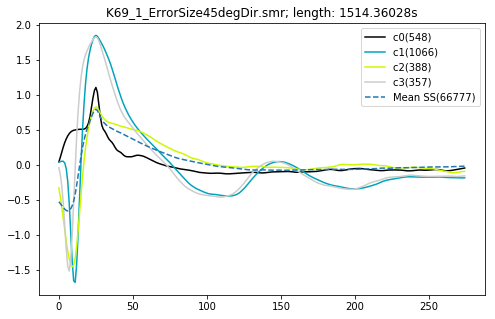

Enter channel index to analyze:3


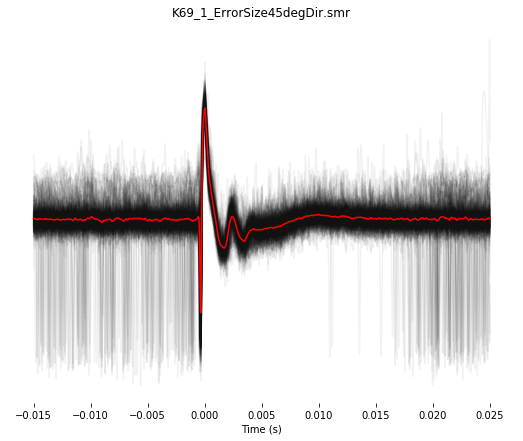

In [6]:
# for f_index in np.arange(0, file_names.size):
for f_index in np.arange(20, 21):
# f_index = 23
    try:
        filename = find_file(os.path.basename(file_names[f_index])+'.pkl', '../data/david_neurons')
        filename

        csv_filename = filename + '.GMM.CS.csv'
        cs_mean_img_filename = '../data/plots/For_cssorter_paper/cs_diversity/', os.path.basename(file_names[f_index]) + '.4GMM.png'
        trace_img_filename = filename + '.trace.4GMM.png'
        csv_filename

        with open(filename, 'rb') as input:
            try:
                sss = pickle.load(input, encoding='latin1')
            except TypeError:
                sss = pickle.load(input)



        pre_time = 0.0005
        post_time = 0.005

        pre_index = int(np.round(pre_time/sss.dt))
        post_index = int(np.round(post_time/sss.dt))
        aligned_cs = np.array([sss.voltage[i - pre_index : i + post_index] for i in sss.cs_indices])

        
        import random

        ss_indices = np.setdiff1d(sss.spike_indices, sss.cs_indices)
        aligned_ss = np.array([sss.voltage[i - pre_index : i + post_index] for i in ss_indices[1:-2]])


        mean_ss = np.mean(aligned_ss[random.sample(range(0, aligned_ss.shape[0]), sss.cs_indices.size), ], axis=0)
#         mean_ss = np.mean(aligned_ss, axis=0)
        pre_time = 0.015
        post_time = 0.025

        pre_index = int(np.round(pre_time/sss.dt))
        post_index = int(np.round(post_time/sss.dt))
        aligned_cs_for_plot = np.array([sss.voltage[i - pre_index : i + post_index] for i in sss.cs_indices])
        aligned_ss_for_plot = np.array([sss.voltage[i - pre_index : i + post_index] for i in ss_indices[50:-50]])


        num_clusters = 4
        gmm = GaussianMixture(num_clusters, covariance_type = 'full').fit(aligned_cs)

        cluster_labels = gmm.predict(aligned_cs)

        clusters = []
        for cn in np.arange(num_clusters):
            clusters.append(aligned_cs[np.where(cluster_labels == cn)])
            
        clusters_for_plot = []
        for cn in np.arange(num_clusters):
            clusters_for_plot.append(aligned_cs_for_plot[np.where(cluster_labels == cn)])

        colors = plt.cm.nipy_spectral(np.linspace(0,1,num_clusters))
        legend_labels = []
        for cn in np.arange(num_clusters):
            legend_labels.append('c{}({}) '.format(cn, clusters[cn].shape[0]))

        import gc
        gc.collect()
        plt.figure(figsize=(8,5))
        # ax2 = plt.subplot(122)
        for cn in np.arange(num_clusters):
            plt.plot(np.mean(clusters[cn], axis=0), color = colors[cn], label = legend_labels[cn])
        plt.plot(mean_ss, '--', label = 'Mean SS({})'.format(aligned_ss.shape[0]))
        # plt.show()    
        plt.legend() 
        plt.title('{}; length: {}s'.format(os.path.basename(file_names[f_index]),sss.voltage.shape[0]*sss.dt))
#         print('Saving {} ... '.format(cs_mean_img_filename))
#         plt.savefig(cs_mean_img_filename)
        plt.show()
        which_cluster = int(raw_input('Enter channel index to analyze:'))

        plt.close()
        
        
#         rand_ind = np.random.randint(0,clusters[which_cluster].shape[0])
        fig = plt.figure(figsize=(9,7))
        plt.plot(np.linspace(-1*pre_time, post_time, clusters_for_plot[which_cluster].shape[1]), clusters_for_plot[which_cluster].T, color = 'k', alpha=0.05)
        plt.plot(np.linspace(-1*pre_time, post_time, clusters_for_plot[which_cluster].shape[1]), np.mean(clusters_for_plot[which_cluster], axis=0), color = 'r')
        plt.title('{}'.format(os.path.basename(file_names[f_index])))
        plt.yticks([])
        plt.xlabel('Time (s)')
        plt.box(on=None)
#         plt.savefig('../data/plots/For_cssorter_paper/cs_diversity_wide/'+ os.path.basename(file_names[f_index]) + '.mean_cs.eps', transparent=True)
        plt.savefig('../data/plots/For_cssorter_paper/cs_diversity_wide/'+ os.path.basename(file_names[f_index]) + '.mean_cs_for_ehsan.svg', transparent=True)
        plt.savefig('../data/plots/For_cssorter_paper/cs_diversity_wide/'+ os.path.basename(file_names[f_index]) + '.mean_cs_for_ehsan.png', transparent=True)
        
#         plt.xticks(np.linspace(-1*pre_time, post_time, ))
                     
                 
                 
        
        
        
#         plt.figure(figsize=(8,10))
#         ax1 = plt.subplot(511)
#         randind = random.sample(np.arange(2,clusters[0].shape[0]-2), 1)
#         plt.plot(clusters_for_plot[0][randind[0],:])
#         plt.ylabel('c0')
#         plt.title('{}; length: {}s'.format(os.path.basename(file_names[f_index]),sss.voltage.shape[0]*sss.dt))

        
#         ax2 = plt.subplot(512)
#         randind = random.sample(np.arange(2,clusters[1].shape[0]-2), 1)
#         plt.plot(clusters_for_plot[1][randind[0],:])
#         plt.ylabel('c1')
        
        
#         ax3 = plt.subplot(513)
#         randind = random.sample(np.arange(2,clusters[2].shape[0]-2), 1)
#         plt.plot(clusters_for_plot[2][randind[0],:])
#         plt.ylabel('c2')
        
        
#         ax4 = plt.subplot(514)
#         randind = random.sample(np.arange(2, clusters[3].shape[0]-2), 1)
#         plt.plot(clusters_for_plot[3][randind[0],:])
#         plt.ylabel('c3')
        
#         ax5 = plt.subplot(515)
#         randind = random.sample(np.arange(2, aligned_ss_for_plot.shape[0]-2), 1)
#         plt.plot(aligned_ss_for_plot[randind[0],:])
#         plt.ylabel('SS')
        
#         print('Saving {} ... '.format(trace_img_filename))
#         plt.savefig(trace_img_filename)
#         plt.close()
        
    except Exception as e:
        print(e.message)
        pass


In [13]:
from scipy.io import savemat
savemat('../data/'+os.path.basename(file_names[f_index])+'aligned_cs.mat', {'aligned_cs':clusters_for_plot[which_cluster]})

In [34]:
clusters[2].shape

(159, 550)

In [27]:
clusters[cn].shape


(162, 550)

In [17]:
import numpy as np
np.random.randint(0,10)

7

array([0.36768683, 0.94545497, 0.4412764 , 0.76218174, 0.49291795,
       0.7246436 , 0.90374136, 0.42550168, 0.47753367, 0.23864602])

<IPython.core.display.Javascript object>


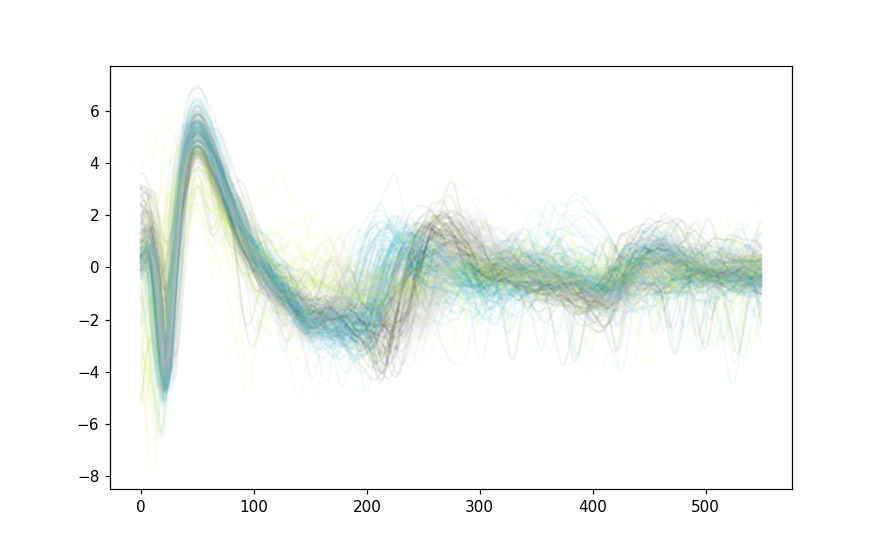

In [265]:
import gc
gc.collect()

plt.figure(figsize=(8,5))
# ax1 = plt.subplot(121)

for cn in np.arange(num_clusters):
    plt.plot(clusters[cn].T, color = colors[cn], alpha = 0.05)
plt.show()

In [18]:
print('Signal length: {} (s)'.format(sss.voltage.shape[0]*sss.dt))
for cn in np.arange(num_clusters):
    print('# of samples in c{}: {}'.format(cn, clusters[cn].shape[0]))

Signal length: 4148.76814 (s)
# of samples in c0: 2132
# of samples in c1: 1474
# of samples in c2: 850
# of samples in c3: 1015


In [133]:
clusters_to_pick = [0,4,2,5]
num_cs = 0
for ctp in clusters_to_pick:
    num_cs = num_cs + clusters[ctp].shape[0]
    
print('Number of cs in clusters {} is {}'.format(clusters_to_pick, num_cs))
    

Number of cs in clusters [0, 4, 2, 5] is 873


In [101]:
isCS = np.ones((sss.cs_indices.size, 2), dtype=sss.cs_indices.dtype)*-1
isCS[:,0] = sss.cs_indices

for ctp in clusters_to_pick:
    isCS[np.where(cluster_labels == ctp), 1] = 1


In [102]:
with open(csv_filename, 'w+') as f:
    print('writing {} ... '.format(csv_filename))
    f.seek(0)
    csvwriter = csv.writer(f, delimiter = ',')
    csvwriter.writerows(isCS)


writing ../data/david_neurons/S34/error_direction/S34_1_directionaltuning.smr.pkl.GMM.CS.csv ... 


In [103]:
print('Saving {} ... '.format(cs_mean_img_filename))
plt.savefig(cs_mean_img_filename)


Saving ../data/david_neurons/S34/error_direction/S34_1_directionaltuning.smr.pkl.png ... 


<IPython.core.display.Javascript object>


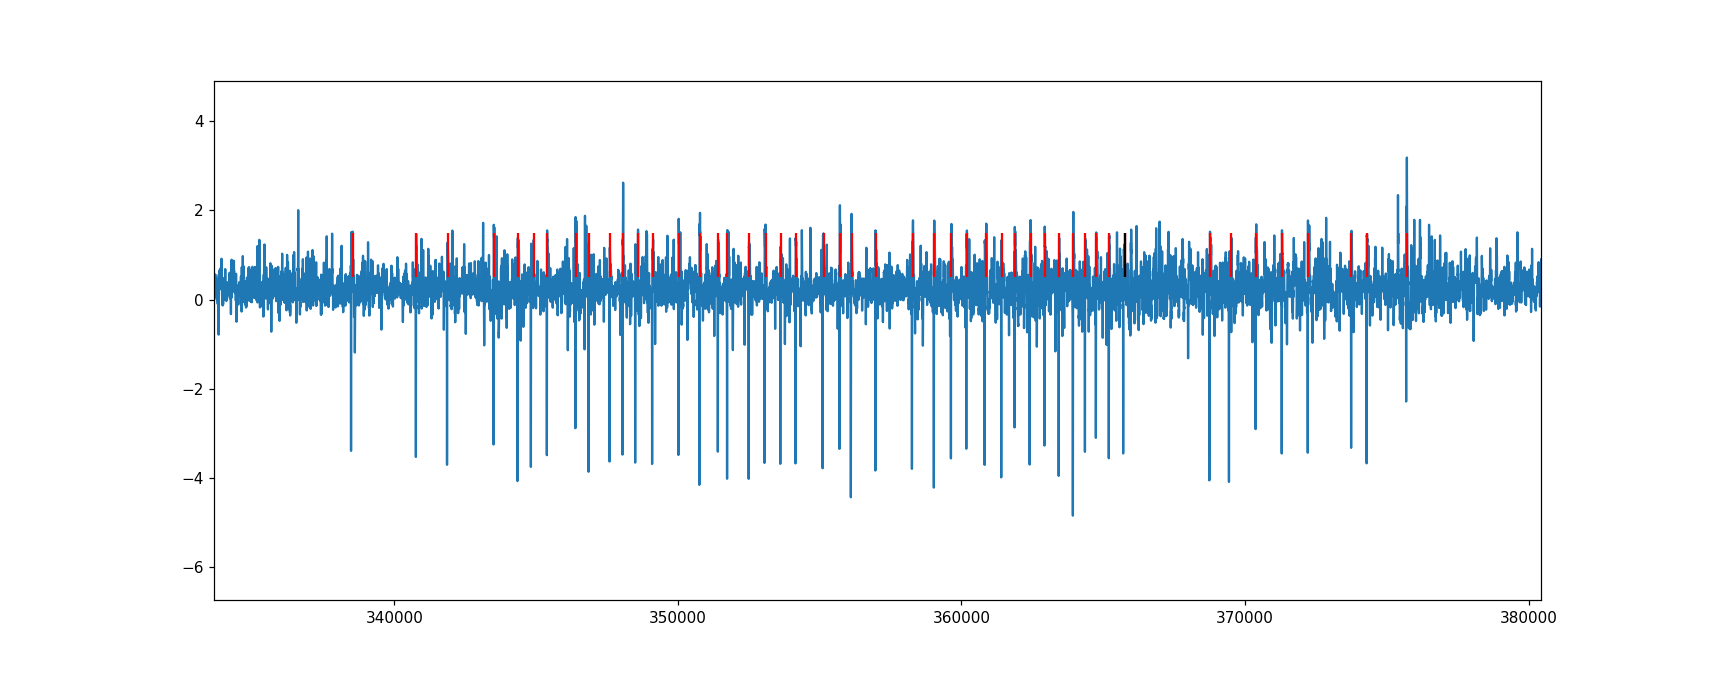

In [213]:
plt.figure()
plt.plot(sss.voltage[0:2500000])
plt.eventplot(sss.spike_indices[0:1000], colors='r', zorder = 10)
plt.eventplot(sss.cs_indices[0:100], colors='k', zorder = 11)